In [1]:
import mplfinance as mpf
import pandas as pd
from pandas_datareader import data as web
import yfinance as yf

In [2]:
yf.pdr_override()

In [3]:
start = '2020-01-01'
end = '2021-07-07'

In [4]:
data = web.get_data_yahoo('aapl', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


# MACD Function

In [5]:
def macd_func(df, a=12, b=21, c=9):
    EMA_short = df['Close'].ewm(span=a, adjust=False, min_periods=a+1).mean()
    EMA_long = df['Close'].ewm(span=b, adjust=False, min_periods=b+1).mean()
    MACD = EMA_short - EMA_long
    signal = MACD.ewm(span=c, adjust=False, min_periods=c+1).mean()
    
    df['macd'] = MACD
    df['signal_line'] = signal
    df['histogram'] = df['macd'] - df['signal_line']
    
    df['shift_hist'] = df['histogram'].shift(1)
    df[(df['histogram'] > 0) & (df['shift_hist'] < 0)]
    df.loc[(df['histogram'] > 0) & (df['shift_hist'] < 0), 'action'] = 'buy'
    df.loc[(df['histogram'] < 0) & (df['shift_hist'] > 0), 'action'] = 'sell'
    df.loc[df['action'] == 'buy', 'marker_position'] = df['Low'] * 0.98
    df.loc[df['action'] == 'sell', 'marker_position'] = df['High'] * 1.02
    
    return df

In [6]:
apple_macd = macd_func(data, 12, 26, 9)

In [7]:
#apple_macd 
apple_macd[apple_macd['action'] == 'sell']

,Open,High,Low,Close,Adj Close,Volume,macd,signal_line,histogram,shift_hist,action,marker_position
Date,,,,,,,,,,,,
2020-05-27,79.035004,79.677498,78.272499,79.527496,78.877037,112945200,2.505659,2.531929,-0.026270,0.029450,sell,81.271048
2020-06-29,88.312500,90.542503,87.820000,90.445000,89.705254,130646000,3.115261,3.146689,-0.031428,0.009536,sell,92.353353
2020-07-17,96.987503,97.147499,95.839996,96.327499,95.539635,92186800,3.320542,3.346937,-0.026394,0.086410,sell,99.090449
2020-07-21,99.172501,99.250000,96.742500,97.000000,96.206642,103433200,3.228542,3.323922,-0.095380,0.003322,sell,101.235000
2020-09-03,126.910004,128.839996,120.500000,120.879997,120.107483,257599600,6.624984,6.841405,-0.216421,0.616050,sell,131.416796
2020-10-21,116.669998,118.709999,116.449997,116.870003,116.123123,89946000,1.050432,1.068023,-0.017591,0.142827,sell,121.084199
2020-11-23,117.180000,117.620003,113.750000,113.849998,113.317581,127959300,0.488706,0.651288,-0.162583,0.178203,sell,119.972403
2021-01-05,128.889999,131.740005,128.429993,131.009995,130.397324,97664900,3.225528,3.371608,-0.146080,0.044663,sell,134.374806
2021-02-01,133.750000,135.380005,130.929993,134.139999,133.512680,106239800,2.563910,2.754637,-0.190727,0.100906,sell,138.087605


In [8]:
def macd_plot(df_plot):
    df = macd_func(df_plot)
    # plot MACD
    mpf_macd = mpf.make_addplot(df['macd'], panel=1, color='blue', title='MACD')
    mpf_signal = mpf.make_addplot(df['signal_line'], panel=1, color='orange')
    
    colors = ['green' if value >= 0 else 'red' for value in df['histogram']]
    mpf_histogram = mpf.make_addplot(df['histogram'], type='bar', panel=1, color=colors)
    
    # marker
    markers = ['^' if x == 'buy' else 'v' for x in df['action']]
    color_marker = ['green' if x == 'buy' else 'red' for x in df['action']]
    plot_signal = mpf.make_addplot(df['marker_position'], type='scatter', markersize=30, marker=markers, color=color_marker)
    
    plots = [mpf_macd, mpf_signal, mpf_histogram, plot_signal]
    
    return plots

In [9]:
a = macd_plot(data)

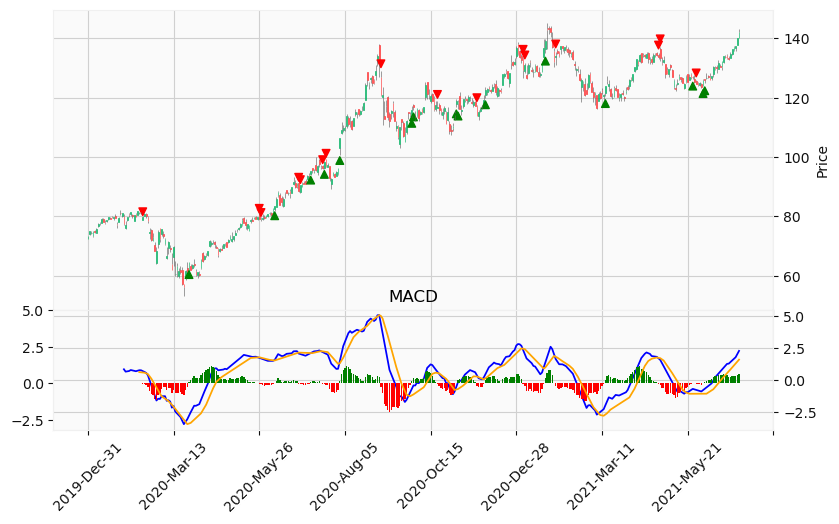

In [10]:
mpf.plot(data, type='candle', style='yahoo', addplot=a, figsize=(10, 6))

# Backtesting MACD

In [11]:
test = data.copy()

In [16]:
test.head(5)['Open']

Date
2019-12-31    72.482498
2020-01-02    74.059998
2020-01-03    74.287498
2020-01-06    73.447502
2020-01-07    74.959999
Name: Open, dtype: float64

In [17]:
test.head(5)['Open'].shift(-1)

Date
2019-12-31    74.059998
2020-01-02    74.287498
2020-01-03    73.447502
2020-01-06    74.959999
2020-01-07          NaN
Name: Open, dtype: float64

In [18]:
test['action_price'] = test['Open'].shift(-1)

In [21]:
test_record = test[test.action.notnull()]
test_record['return'] = test_record['action_price'].pct_change()
test_record.head(5)

<ipython-input-21-b3aa723d8027>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_record['return'] = test_record['action_price'].pct_change()


,Open,High,Low,Close,Adj Close,Volume,macd,signal_line,histogram,shift_hist,action,marker_position,action_price,return
Date,,,,,,,,,,,,,,
2020-02-18,78.839996,79.937500,78.652496,79.750000,78.884193,152531200,0.671031,0.749893,-0.078862,0.009145,sell,81.536250,80.000000,NaN
2020-03-26,61.630001,64.669998,61.590000,64.610001,63.908562,252087200,-2.642528,-2.759475,0.116947,-0.236904,buy,60.358200,63.187500,-0.210156
2020-05-26,80.875000,81.059998,79.125000,79.182503,78.534874,125522000,1.745515,1.781821,-0.036307,0.026183,sell,82.681198,79.035004,0.250801
2020-05-27,79.035004,79.677498,78.272499,79.527496,78.877037,112945200,1.687764,1.763010,-0.075246,-0.036307,sell,81.271048,79.192497,0.001993
2020-06-08,82.562500,83.400002,81.830002,83.364998,82.683151,95654400,1.576309,1.563797,0.012512,-0.049591,buy,80.193402,83.035004,0.048521


In [35]:
def strategy_return(df, action_price='Open', long_or_short='long'):
    action_df = df.loc[df['action'].notnull()]

    if action_price == 'Open':
        df['action_price'] = df['Open'].shift(-1)
        action_df['return'] = action_df['action_price'].pct_change()

    elif action_price == 'Close':
        df['action_price'] = df['Close']
        action_df['return'] = action_df['action_price'].pct_change()
        
    elif action_price == 'Adj Close':
        df['action_price'] = df['Adj Close']
        action_df['return'] = action_df['Adj Close'].pct_change()
        
    else:
        raise ValueError('Incorrect action price, choose between {Open, Close, Adj Close}')
 
    record_df = action_df[['action', 'action_price', 'return']]
    record_df.reset_index(inplace=True)
    record_df['previous_signal_date'] = record_df['Date'].shift(1)
    record_df['previous_action'] = record_df['action'].shift(1)
    record_df['previous_action_price'] = record_df['action_price'].shift(1)
    record_df.rename(columns={'Date': 'signal_date'}, inplace=True)
    
    if long_or_short == 'long':
        summary_df = record_df[record_df.action == 'sell']
        print('long strategy')
        
    elif long_or_short == 'short':
        summary_df = record_df[record_df.action == 'buy']
        summary_df['return'] = summary_df['return'] * -1
        print('short strategy')
        
    else:
        raise ValueError('Incorrect long_or_short, choose between {long, short}')
        
    return action_df, record_df, summary_df

In [36]:
starter = macd_func(data)

In [37]:
a, b, c = strategy_return(starter)
# action_df = starter.loc[starter['action'].notnull()]
# action_df['action_price'].pct_change()

long strategy


<ipython-input-35-a1350070bbec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  action_df['return'] = action_df['action_price'].pct_change()
<ipython-input-35-a1350070bbec>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record_df['previous_signal_date'] = record_df['Date'].shift(1)
<ipython-input-35-a1350070bbec>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [39]:
a.head(10)

,Open,High,Low,Close,Adj Close,Volume,macd,signal_line,histogram,shift_hist,action,marker_position,action_price,return
Date,,,,,,,,,,,,,,
2020-02-18,78.839996,79.937500,78.652496,79.750000,78.884193,152531200,0.671031,0.749893,-0.078862,0.009145,sell,81.536250,80.000000,NaN
2020-03-26,61.630001,64.669998,61.590000,64.610001,63.908562,252087200,-2.642528,-2.759475,0.116947,-0.236904,buy,60.358200,63.187500,-0.210156
2020-05-26,80.875000,81.059998,79.125000,79.182503,78.534874,125522000,1.745515,1.781821,-0.036307,0.026183,sell,82.681198,79.035004,0.250801
2020-05-27,79.035004,79.677498,78.272499,79.527496,78.877037,112945200,1.687764,1.763010,-0.075246,-0.036307,sell,81.271048,79.192497,0.001993
2020-06-08,82.562500,83.400002,81.830002,83.364998,82.683151,95654400,1.576309,1.563797,0.012512,-0.049591,buy,80.193402,83.035004,0.048521
2020-06-26,91.102501,91.330002,88.254997,88.407501,87.684418,205256800,2.080347,2.102524,-0.022178,0.156702,sell,93.156602,88.312500,0.063557
2020-06-29,88.312500,90.542503,87.820000,90.445000,89.705254,130646000,2.037620,2.089543,-0.051923,-0.022178,sell,92.353353,90.019997,0.019335
2020-07-08,94.180000,95.375000,94.089996,95.342499,94.562691,117092000,2.114395,2.033696,0.080699,-0.017281,buy,92.208196,96.262497,0.069346
2020-07-17,96.987503,97.147499,95.839996,96.327499,95.539635,92186800,2.155697,2.193777,-0.038080,0.050455,sell,99.090449,96.417503,0.001610


In [40]:
b.head(10)

,signal_date,action,action_price,return,previous_signal_date,previous_action,previous_action_price
0,2020-02-18,sell,80.000000,NaN,NaT,NaN,NaN
1,2020-03-26,buy,63.187500,-0.210156,2020-02-18,sell,80.000000
2,2020-05-26,sell,79.035004,0.250801,2020-03-26,buy,63.187500
3,2020-05-27,sell,79.192497,0.001993,2020-05-26,sell,79.035004
4,2020-06-08,buy,83.035004,0.048521,2020-05-27,sell,79.192497
5,2020-06-26,sell,88.312500,0.063557,2020-06-08,buy,83.035004
6,2020-06-29,sell,90.019997,0.019335,2020-06-26,sell,88.312500
7,2020-07-08,buy,96.262497,0.069346,2020-06-29,sell,90.019997
8,2020-07-17,sell,96.417503,0.001610,2020-07-08,buy,96.262497
9,2020-07-20,buy,99.172501,0.028574,2020-07-17,sell,96.417503


In [41]:
c.head(10)

,signal_date,action,action_price,return,previous_signal_date,previous_action,previous_action_price
0,2020-02-18,sell,80.000000,NaN,NaT,NaN,NaN
2,2020-05-26,sell,79.035004,0.250801,2020-03-26,buy,63.187500
3,2020-05-27,sell,79.192497,0.001993,2020-05-26,sell,79.035004
5,2020-06-26,sell,88.312500,0.063557,2020-06-08,buy,83.035004
6,2020-06-29,sell,90.019997,0.019335,2020-06-26,sell,88.312500
8,2020-07-17,sell,96.417503,0.001610,2020-07-08,buy,96.262497
10,2020-07-21,sell,96.692497,-0.025007,2020-07-20,buy,99.172501
12,2020-09-03,sell,120.070000,0.109704,2020-07-31,buy,108.199997
15,2020-10-21,sell,117.449997,0.040393,2020-10-01,buy,112.889999
18,2020-11-23,sell,113.910004,-0.054689,2020-11-06,buy,120.500000


<AxesSubplot:>

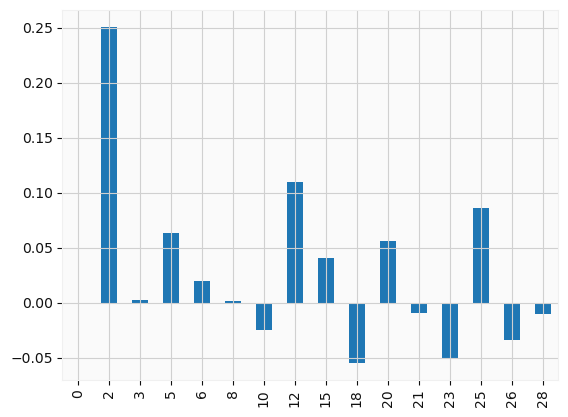

In [42]:
c['return'].plot(kind='bar')